In [1]:
import torch

torch.cuda.is_available()

True

In [26]:
from torchvision import transforms
from torchvision.datasets import VOCSegmentation
from torch.utils.data import DataLoader

transform = transforms.Compose(
    [
        transforms.Resize((128,128)),
        transforms.ToTensor()
    ]
)

# Load Training Dataset (Train 2012)
train_dataset = VOCSegmentation(root='./data', year='2012', image_set='train', download=True, transform=transform, target_transform=transform)

# Load Test Dataset (Val 2012, since VOC does not have a separate test set)
test_dataset = VOCSegmentation(root='./data', year='2012', image_set='val', download=True, transform=transform, target_transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

Using downloaded and verified file: ./data\VOCtrainval_11-May-2012.tar
Extracting ./data\VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data\VOCtrainval_11-May-2012.tar
Extracting ./data\VOCtrainval_11-May-2012.tar to ./data


In [23]:
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=21):
        super(UNet, self).__init__()

        # Encoder (Downsampling)
        self.enc1 = self.conv_block(in_channels, 32)
        self.enc2 = self.conv_block(32, 64)
        self.enc3 = self.conv_block(64, 128)
        self.enc4 = self.conv_block(128,256)

        # Bottleneck
        self.bottleneck = self.conv_block(256, 512)

        # Decoder (Upsampling)
        self.up4 = self.up_sample(512,256)
        self.up_conv4 = self.conv_block(512,256)
        self.up3 = self.up_sample(256,128)
        self.up_conv3 = self.conv_block(256, 128)
        self.up2 = self.up_sample(128, 64)
        self.up_conv2 = self.conv_block(128,64)
        self.up1 = self.up_sample(64, 32)
        self.up_conv1 = self.conv_block(64,32)

        # Final Output Layer
        self.final_conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        """Convolutional block: 2 conv layers + ReLU"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def up_sample(self, in_channels, out_channels):
        """Upsampling + Convolution"""
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(F.max_pool2d(e1, kernel_size=2, stride=2))
        e3 = self.enc3(F.max_pool2d(e2, kernel_size=2, stride=2))
        e4 = self.enc4(F.max_pool2d(e3, kernel_size=2, stride=2))

        # Bottleneck
        b = self.bottleneck(F.max_pool2d(e4, kernel_size=2, stride=2))

        # Decoder with Skip Connections
        d4 = self.up4(b)  # upsample
        d4 = torch.cat([d4,e4],dim=1) #skip connection
        d4 = self.up_conv4(d4) #convolution
        d3 = self.up3(d4)  # upsample
        d3 = torch.cat([d3,e3],dim=1) #skip connection
        d3 = self.up_conv3(d3) #convolution
        d2 = self.up2(d3)  # upsample
        d2 = torch.cat([d2,e2],dim=1) #skip connection
        d2 = self.up_conv2(d2) #convolution
        d1 = self.up1(d2)  # upsample
        d1 = torch.cat([d1,e1],dim=1) #skip connection
        d1 = self.up_conv1(d1) #convolution

        # Final output layer
        return self.final_conv(d1)
    
    

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize Model
model = UNet(in_channels=3, out_channels=21).to(device)  # 21 classes for Pascal VOC

# Loss and Optimizer
weights = torch.tensor([0.2] + [1.0] * 20).to(device) 
criterion = nn.CrossEntropyLoss(weight=weights)  # Use CrossEntropyLoss for multi-class segmentation
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# Training Loop
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device, dtype=torch.long)  # Convert masks to long type

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.squeeze(1))  # Squeeze to match shape
        loss.backward()
        optimizer.step()
        
    epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/3, Loss: 1.1287
Epoch 2/3, Loss: 0.5075
Epoch 3/3, Loss: 0.4523


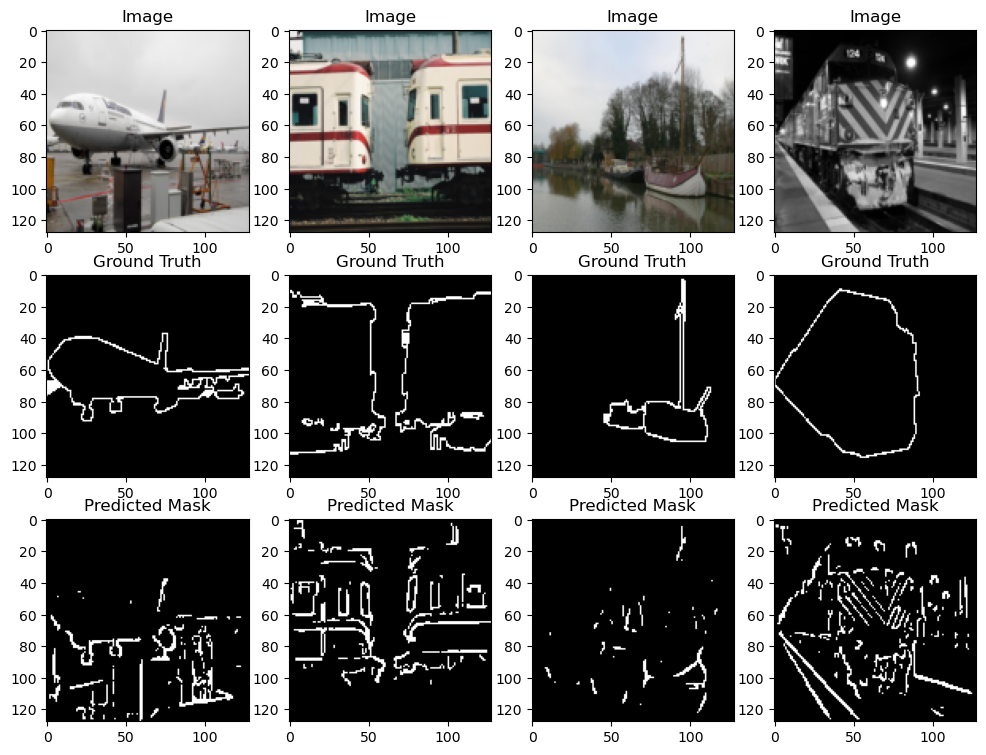

In [30]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    images, masks = next(iter(test_loader))
    images, masks = images.to(device), masks.to(device, dtype=torch.long)
    
    outputs = model(images)
    predicted_masks = torch.argmax(outputs, dim=1)
     
    # Convert to numpy for visualization
    images_np = images.cpu().permute(0, 2, 3, 1).numpy()
    masks_np = masks.squeeze(1).cpu().numpy()
    preds_np = predicted_masks.cpu().numpy()

    # Plot sample image, ground truth mask, and predicted mask
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    for i in range(4):  # Show 4 samples
        axes[0, i].imshow(images_np[i])
        axes[0, i].set_title("Image")
        axes[1, i].imshow(masks_np[i], cmap="gray")
        axes[1, i].set_title("Ground Truth")
        axes[2, i].imshow(preds_np[i], cmap="gray")
        axes[2, i].set_title("Predicted Mask")
    plt.show()